`Car parking lot vacancy detection using transfer learning on Resnet50 network implemented with PyTorch.`

Import libraries

In [0]:
model_no = '5' # change on each iteration

In [0]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import time
from PIL import Image
import shutil
import os

Mount Google Drive; fetch and extract dataset

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd /content/
!mkdir dataset
shutil.copy('/content/drive/My Drive/datasets/carpark.tar', '/content/dataset' )
%cd /content/dataset
!ls

/content
mkdir: cannot create directory ‘dataset’: File exists
/content/dataset
carpark.tar


In [0]:
!tar -xvf 'carpark.tar'

Streaming output truncated to the last 5000 lines.
carpark/test_set/busy/4705.jpg
carpark/test_set/busy/1927.jpg
carpark/test_set/busy/10277.jpg
carpark/test_set/busy/2587.jpg
carpark/test_set/busy/14873.jpg
carpark/test_set/busy/15440.jpg
carpark/test_set/busy/15821.jpg
carpark/test_set/busy/6393.jpg
carpark/test_set/busy/9200.jpg
carpark/test_set/busy/6148.jpg
carpark/test_set/busy/6020.jpg
carpark/test_set/busy/9028.jpg
carpark/test_set/busy/11268.jpg
carpark/test_set/busy/16946.jpg
carpark/test_set/busy/15801.jpg
carpark/test_set/busy/4474.jpg
carpark/test_set/busy/1227.jpg
carpark/test_set/busy/8848.jpg
carpark/test_set/busy/12541.jpg
carpark/test_set/busy/14634.jpg
carpark/test_set/busy/123.jpg
carpark/test_set/busy/7332.jpg
carpark/test_set/busy/3005.jpg
carpark/test_set/busy/15866.jpg
carpark/test_set/busy/10391.jpg
carpark/test_set/busy/9418.jpg
carpark/test_set/busy/759.jpg
carpark/test_set/busy/8528.jpg
carpark/test_set/busy/13261.jpg
carpark/test_set/busy/17997.jpg
carpark/

In [0]:
os.remove('carpark.tar')
!ls

carpark


In [0]:
# Verify count of training, validation and test sets
%cd /content/dataset/carpark/training_set/free/
!ls | wc -l
%cd /content/dataset/carpark/training_set/busy/
!ls | wc -l
%cd /content/dataset/carpark/test_set/free/
!ls | wc -l
%cd /content/dataset/carpark/test_set/busy/
!ls | wc -l
%cd /content/dataset/carpark/valid_set/free/
!ls | wc -l
%cd /content/dataset/carpark/valid_set/busy/
!ls | wc -l
%cd /content/

/content/dataset/carpark/training_set/free
46877
/content/dataset/carpark/training_set/busy
47616
/content/dataset/carpark/test_set/free
13549
/content/dataset/carpark/test_set/busy
18276
/content/dataset/carpark/valid_set/free
5232
/content/dataset/carpark/valid_set/busy
13416
/content


Loading test and training set

In [0]:
!mkdir results/
# Load training and test set
root_dir = '/content' # **** insert root dir here ***
result_dir = '/content/results/'
training_set = root_dir + '/dataset/carpark/training_set'
valid_set = root_dir + '/dataset/carpark/valid_set'
test_set = root_dir + '/dataset/carpark/test_set'

# Define transformations for the train, validation and test sets
transform_train = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
  #  transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
		transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # image_net values
])

transform_valid = transforms.Compose([
	transforms.Resize(255),
	transforms.CenterCrop(224),
	transforms.ToTensor(),
	transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # image_net values
])

transform_test = transforms.Compose([
	transforms.Resize(255),
	transforms.CenterCrop(224),
	transforms.ToTensor(),
	transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # image_net values
])

# Load the datasets from their folders to the dataloader objects
trainset = datasets.ImageFolder(training_set, transform = transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size = 128, shuffle = True)

validset = datasets.ImageFolder(valid_set, transform = transform_valid)
valid_loader = torch.utils.data.DataLoader(validset, batch_size = 128, shuffle = True)

testset = datasets.ImageFolder(test_set, transform = transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size = 128, shuffle = True)

# Obtain the output class names and the dataset sizes
class_names = trainset.classes
dataset_sizes = [len(trainset), len(validset), len(testset)]


Check if CUDA is available

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


Display sample images

In [0]:
# Function to convert images for display
def image_convert(img):
    img = img.clone().cpu().numpy()
    img = img.transpose(1, 2, 0)
    std = [0.229, 0.224, 0.225]
    mean = [0.485, 0.456, 0.406]
    img = img*std + mean
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


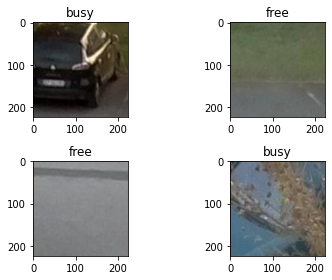

In [0]:
import random

# Print sample images from training set
examples = enumerate(train_loader)
batch_id, (images, targets) = next(examples)
fig = plt.figure()
for i in range(4):
	rand = random.randint(0, 63)
	plt.subplot(2,2,i+1)
	plt.tight_layout()
	plt.imshow(image_convert(images[rand]))
	plt.title(class_names[targets[rand].item()])	# targets is a tensor storing the corresponding class of images
plt.show()


Model and parameter definition 

In [0]:
model = models.resnet50(pretrained=True) # load pretrained ResNet50 Model

# Freeze model parameters
for param in model.parameters():
    param.requires_grad = False

# summary(model, (3, 224, 224), 32, device='cpu') # Display model summary in tensorflow style

fc_inputs = model.fc.in_features # define final layers for transfer learning
 
model.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 2),
    nn.LogSoftmax(dim=1) # To use NLLLoss()
)

model = model.to(device) # send model to CUDA device

# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


Model training


In [0]:
def train_model(model, loss_criterion, optimizer, epochs):
    history = []

    for epoch in range(epochs): # iterate through epochs
        start_time = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))    

        train_loss = 0.0
        train_acc = 0.0
        valid_loss = 0.0
        valid_acc = 0.0
        
        # Training loop
        for i, (inputs, labels) in enumerate(train_loader): # iterate through the training batches
            model.train() # set model to training mode
            inputs = inputs.to(device) # send images to device
            labels = labels.to(device) # send labels to device
            optimizer.zero_grad() # remove existing gradients
            outputs = model(inputs) # compute outputs for the training inputs
            loss = loss_criterion(outputs, labels) # compute loss of the obtained outputs       
            loss.backward() # backpropagate the gradients
            optimizer.step() # update parameters
            
            train_loss += loss.item() * inputs.size(0) # compute and add the total loss of the batch       
            ret, predictions = torch.max(outputs.data, 1) # compute accuracy
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor)) # compute mean accuracy
            train_acc += acc.item() * inputs.size(0) # compute and add total accuracy of the batch
            print("Batch number: {:03d}".format(i))

            
        # Validation loop
        with torch.no_grad():
            model.eval() # set model to evaluation mode
            # Validation loop
            for j, (inputs, labels) in enumerate(valid_loader):
                inputs = inputs.to(device) # send images to device
                labels = labels.to(device) # send labels to device
                outputs = model(inputs) # compute outputs for the present inputs
                loss = loss_criterion(outputs, labels) # compute loss
                valid_loss += loss.item() * inputs.size(0) # compute and add the total loss of the batch
                ret, predictions = torch.max(outputs.data, 1) # compute accuracy
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor)) # compute mean accuracy
                valid_acc += acc.item() * inputs.size(0) # compute and add total accuracy of the batch
                print("Validation Batch number: {:03d}".format(j))

        avg_train_loss = train_loss/dataset_sizes[0] # find average training loss
        avg_train_acc = train_acc/dataset_sizes[0] # find average training accuracy
        avg_valid_loss = valid_loss/dataset_sizes[1] # find average validation loss
        avg_valid_acc = valid_acc/dataset_sizes[1] # find average validation accuracy
        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])               
        end_time = time.time()
        epoch_time = end_time - start_time
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_time))
        
    return model, history

In [37]:
# Train the model for 10 epochs
num_epochs = 10
trained_model, history_result = train_and_validate(model, loss_func, optimizer, num_epochs)
torch.save(history, result_dir + 'carpark_' + model_no + '_history.pt')
torch.save(model, result_dir + 'carpark_' + model_no + '.pt')

Epoch: 1/10
Batch number: 000
Batch number: 001
Batch number: 002
Batch number: 003
Batch number: 004
Batch number: 005
Batch number: 006


KeyboardInterrupt: ignored

Plotting loss and accuracy curves

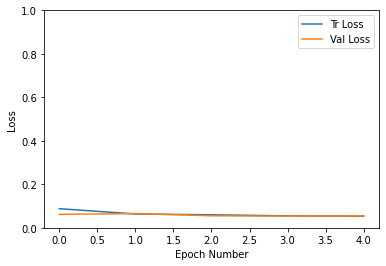

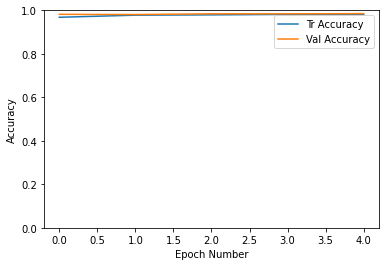

In [0]:
# Loss curve
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig('loss_curve.png')
plt.show()

# Accuracy curve
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig('accuracy_curve.png')
plt.show()

Testing the accuracy of the model

In [0]:
def computeTestSetAccuracy(model, loss_criterion):

    test_acc = 0.0
    test_loss = 0.0

    with torch.no_grad(): # turn off gradient tracking
        model.eval() # set model to evaluate mode
        for j, (inputs, labels) in enumerate(test_loader): # iterate through test set batches
            inputs = inputs.to(device) # send images to device
            labels = labels.to(device) # send labels to device
            outputs = model(inputs) # compute outputs for the present inputs
            loss = loss_criterion(outputs, labels) # compute loss
            test_loss += loss.item() * inputs.size(0) # compute and add the total loss of the batch
            ret, predictions = torch.max(outputs.data, 1) # compute accuracy
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor)) # compute mean accuracy
            test_acc += acc.item() * inputs.size(0) # compute and add total accuracy of the batch
            print("Test Batch number: {:03d}".format(j))

    # Find average test loss and test accuracy
    avg_test_loss = test_loss/dataset_sizes[2]
    avg_test_acc = test_acc/dataset_sizes[2]
    print("Test accuracy : " + str(avg_test_acc))

In [39]:
computeTestSetAccuracy(model, loss_func)

Test Batch number: 000
Test Batch number: 001
Test Batch number: 002
Test Batch number: 003
Test Batch number: 004
Test Batch number: 005
Test Batch number: 006
Test Batch number: 007


KeyboardInterrupt: ignored

Copy results to Google Drive - **change file names**


In [0]:
%cd /content/
!tar -cvf result_3.tar results/ # change each iteration

In [0]:
%cd /content/results/
!ls

In [0]:
data = '/content/result_3.tar'
target = '/content/drive/My Drive/result_3.tar'
shutil.copy(data, target)

In [0]:
%cd /content/drive/My\ Drive
!ls

/content/drive/My Drive
 Code		   'Final Year Project'    result_1.tar   trained_models
'Colab Notebooks'  'Getting started.pdf'   result_2.tar
 datasets	   'Jupyter Notebooks'	   result_3.tar


Deleting result files

In [0]:
file1 = '/content/results/carpark_10.pt'
file2 = '/content/results/carpark_' + str(model_no) + '.pt'
file3 = '/content/results/carpark_' + str(model_no) + '_history.pt'
os.remove(file1)
os.remove(file2)
os.remove(file3)
%cd /content/results
!ls


/content/results
